# Retrieval and extraction of information from a YouTube channel page using web scraping.
- **Libraries Used**:
  - `requests`: Handles HTTP requests and fetches the HTML content from the URL.
  - `BeautifulSoup`: Parses the HTML content to extract specific details (title, description, and keywords).

- **Functionality**:
  1. The `get_channel_info` function accepts a YouTube channel URL.
  2. It makes an HTTP GET request to retrieve the HTML content.
  3. If the page fetch fails (non-200 status code), the function prints an error message and returns `None`.
  4. It uses BeautifulSoup to parse the HTML:
     - Extracts the **channel title** from the `<title>` tag.
     - Extracts the **channel description** from the `<meta>` tag (if present).
     - Extracts **keywords** from another `<meta>` tag (if available).
  5. The function returns a dictionary containing the `title`, `description`, and `keywords` of the channel.

- **Output**:
  The extracted channel information (title, description, and keywords) is printed and returned as a dictionary.

In [ ]:
import requests
from bs4 import BeautifulSoup

def get_channel_info(channel_url):
    # Fetch the HTML content of the channel
    response = requests.get(channel_url)
    if response.status_code != 200:
        print("Failed to retrieve page.")
        return None

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')

    # Try finding the title from the HTML <title> tag
    channel_title = soup.find('title').text if soup.find('title') else "No title found"

    # You might not find description/meta tags, so handle gracefully
    description_tag = soup.find('meta', {'name': 'description'})
    channel_description = description_tag['content'] if description_tag else "No description found"

    # Attempt to get keywords from another meta tag
    keywords_tag = soup.find('meta', {'name': 'keywords'})
    keywords = keywords_tag['content'] if keywords_tag else "No keywords found"

    print(f"Channel Title: {channel_title}")
    print(f"Channel Description: {channel_description}")
    print(f"Keywords: {keywords}")

    return {
        'title': channel_title,
        'description': channel_description,
        'keywords': keywords
    }

# Example Usage
channel_url = "https://www.youtube.com/@RebalD"
channel_info = get_channel_info(channel_url)

Channel Title: Rebal D - YouTube
Channel Description: Hey there best friend, this is the channel where i make commentary and reaction videos saying everything that you're thinking but don't want to say. Fun. Bus...
Keywords: "rebal d" rebald "rebal d channel" "rebal d musical.ly" "rebel d vines" "rebal d reacting" "rebel d reacting" "rebeld reacting" "rebel d reaction" "rebeld re...


# Retrieval of video data
This Python code utilizes the **YouTube Data API** to retrieve and analyze videos from a specific YouTube channel. It makes use of the `googleapiclient` and `pandas` libraries to interact with the API and handle the data.

- **Libraries Used**:
  - `googleapiclient.discovery`: For interacting with the YouTube Data API.
  - `pandas`: To structure and analyze the fetched data.

- **Functionality**:
  1. **YouTube API Key**: The code fetches the API key securely via the Colab environment's `userdata`.
  2. **Build YouTube Client**: A YouTube client is created using the `build()` function.
  3. **get_channel_videos Function**:
     - Fetches the **playlist ID** that contains all uploads for the specified channel ID.
     - Retrieves videos from this playlist in batches (pagination using next page tokens).
     - For each video, it extracts metadata like **title**, **description**, **publish date**, **view count**, **like count**, and **comment count**.
  4. The video details are stored in a list of dictionaries and later converted into a **Pandas DataFrame**.
  5. **Data Analysis**:
     - Converts numeric columns to integers and the publish date to a datetime format.
     - Displays basic **summary statistics** for the dataset.
  
- **Output**:
  - A CSV file (`rebal_d_videos.csv`) containing the videos' metadata is saved.
  - The DataFrame is analyzed for its structure and numeric details.

In [ ]:
from googleapiclient.discovery import build
import pandas as pd

#Insert your API key here
API_KEY = '###'

# Build a YouTube client object
youtube = build('youtube', 'v3', developerKey=API_KEY)

def get_channel_videos(channel_id):
    # First, get the playlist ID that contains all channel uploads
    request = youtube.channels().list(
        part='contentDetails',
        id=channel_id
    )
    response = request.execute()

    # Check if the response contains items
    if 'items' not in response or len(response['items']) == 0:
        print("No items found in the response. Check if the channel ID is correct.")
        return None

    # The uploads playlist contains all the videos from the channel
    uploads_playlist_id = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']

    # Fetch videos from the playlist
    videos = []
    next_page_token = None

    while True:
        playlist_request = youtube.playlistItems().list(
            part='snippet,contentDetails',
            playlistId=uploads_playlist_id,
            maxResults=50,  # Fetch 50 results per page
            pageToken=next_page_token
        )
        playlist_response = playlist_request.execute()

        # Gather video IDs
        video_ids = [item['contentDetails']['videoId'] for item in playlist_response['items']]

        # Get video details in bulk
        video_request = youtube.videos().list(
            part='snippet,statistics',
            id=','.join(video_ids)
        )
        video_response = video_request.execute()

        for video in video_response['items']:
            video_data = {
                'title': video['snippet']['title'],
                'description': video['snippet']['description'],
                'publish_date': video['snippet']['publishedAt'],
                'view_count': video['statistics'].get('viewCount', 'N/A'),
                'like_count': video['statistics'].get('likeCount', 'N/A'),
                'comment_count': video['statistics'].get('commentCount', 'N/A'),
            }
            videos.append(video_data)

        next_page_token = playlist_response.get('nextPageToken')
        if not next_page_token:
            break

    return videos

# Insert channel ID here
channel_id = '###'
videos = get_channel_videos(channel_id)

if videos:
    total_videos = len(videos)
    print(f"Total videos retrieved: {total_videos}")

    # Create DataFrame
    df = pd.DataFrame(videos)
    df.to_csv('rebal_d_videos.csv', index=False)

    # Display the DataFrame information
    print("\nDataFrame Information:")
    print(df.info())

    # Convert numerical columns
    df['view_count'] = df['view_count'].astype(int)
    df['like_count'] = df['like_count'].astype(int)
    df['comment_count'] = df['comment_count'].astype(int)

    # Convert publish_date to datetime
    df['publish_date'] = pd.to_datetime(df['publish_date'])

    # Verify the changes
    print("DataFrame Information after type conversion:")
    print(df.info())

    # Display summary statistics for numeric columns
    print("\nSummary Statistics:")
    print(df.describe())
else:
    print("Failed to retrieve channel videos.")

Total videos retrieved: 329

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          329 non-null    object
 1   description    329 non-null    object
 2   publish_date   329 non-null    object
 3   view_count     329 non-null    object
 4   like_count     329 non-null    object
 5   comment_count  329 non-null    object
dtypes: object(6)
memory usage: 15.5+ KB
None
DataFrame Information after type conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   title          329 non-null    object             
 1   description    329 non-null    object             
 2   publish_date   329 non-null    datetime64[ns, UTC]
 3   view_count     329 n

# Pre-processing and cleaning of video descriptions

The workflow includes:

- **Libraries Used**:
  - `re`: For handling regular expressions to find and remove patterns.
  - `pandas`: To load, process, and save the video descriptions from a CSV file.

- **Functionality**:
  1. **Sponsorship Pattern Cleaning**:
     - A list of advanced regex patterns is created to identify phrases related to sponsorships and promotions.
     - The `clean_description` function applies these patterns and removes the matched text.
  
  2. **Additional Unwanted Phrases**:
     - A separate list of common unwanted phrases (e.g., social media links) is compiled.
     - These are directly replaced with empty strings in the DataFrame using `str.replace()`.

  3. **Data Cleaning**:
     - The video descriptions from `rebal_d_videos.csv` are cleaned based on these patterns.
     - The cleaned descriptions are saved in a new column called `description_cleaned`.

  4. **Saving Cleaned Data**:
     - The cleaned DataFrame is saved to a new CSV file, `rebal_d_videos_cleaned.csv`, for further analysis.
     - A preview of the original and cleaned descriptions is printed for verification.

This way, we ensure that unnecessary and irrelevant content is filtered out from the video descriptions

In [ ]:
import re
import pandas as pd

# Function to clean descriptions with advanced patterns
sponsorship_patterns = [
    r'(?i)big thanks to.*?sponsoring this video',
    r'(?i)thanks to.*?for sponsoring',
    r'(?i)use my link.*',
    r'(?i)get.*?for free.*',
    r'(?i).*? Application',
    r'(?i)go to to upgrade your browser for FREE',
    r'(?i)download .*? to get 100 coupons and find my picks:',
    r'(?i)\bthanks to\b',
    r'(?i)\bsponsored\b',
    r'(?i)\buse my link\b',
    r'(?i)\bdownload\b',
    r'(?i)\bcheck out\b',
    r'(?i)\bget\b',
    r'(?i)\bfor free\b',
    r'(?i)\bjoin\b',
    r'(?i)\bsubscribe\b',
    r'(?i)\bclaim\b',
]

def clean_description(desc):
    # Combine patterns into a single regex
    pattern = r'|'.join(sponsorship_patterns)
    cleaned_description = re.sub(r'([^.]*?(' + pattern + ')[^.]*\.)', '', desc)
    cleaned_description = re.sub(r'\s+', ' ', cleaned_description).strip()
    return cleaned_description

# Combined list of unwanted and ignored phrases
cleaning_phrases = [
    r"~~~~~~~~~~~~~~~~",  # Escape special characters if needed
    r"https://www.instagram.com/rebal_official/",
    r"\(@Rebal_Official\)",  # Escaped parentheses
    r"https://twitter.com/Rebal_D",
    r"\(@Rebal_D\)",
    r"https://www.younow.com/RebalD",
    r"\(@RebalD\)",
    r"a \(@RebalD\)",  # Extra whitespace handled
    r"Try Opera browser FOR FREE here: https://opr.as/08-Opera-browser-rebald",
    r"http://bit.ly/2bSdjlw",
    r"https://bit.ly/2NbtJ6c",
    r"SUBSCRIBE IF YOU'RE A LLAMA RIDER",
    r"DON'T MISS THESE VIDEOS",
    r"Talk to me on",
    r"Instagram:",
    r"Twitter:",
    r"YouNow:"
]

# Load the videos DataFrame from CSV
df = pd.read_csv('rebal_d_videos.csv')

# Clean the descriptions of the videos
# We apply a case-insensitive phrase replacement
for phrase in cleaning_phrases:
    # Using regex=True to handle exact replacements and allow escaping characters
    df['description'] = df['description'].str.replace(phrase, '', regex=True)

# Clean the descriptions using the cleaning function for sponsorship phrases
df['description_cleaned'] = df['description'].apply(clean_description)

# Save the cleaned DataFrame to a new CSV
df.to_csv('rebal_d_videos_cleaned.csv', index=False)

# Preview the cleaned descriptions
print(df[['description', 'description_cleaned']].head())

<ipython-input-3-33eceabcfded>:28: DeprecationWarning: Flags not at the start of the expression '([^.]*?((?i)big than' (truncated) but at position 8
  cleaned_description = re.sub(r'([^.]*?(' + pattern + ')[^.]*\.)', '', desc)
<ipython-input-3-33eceabcfded>:28: DeprecationWarning: Flags not at the start of the expression '([^.]*?((?i)big than' (truncated) but at position 50
  cleaned_description = re.sub(r'([^.]*?(' + pattern + ')[^.]*\.)', '', desc)
<ipython-input-3-33eceabcfded>:28: DeprecationWarning: Flags not at the start of the expression '([^.]*?((?i)big than' (truncated) but at position 81
  cleaned_description = re.sub(r'([^.]*?(' + pattern + ')[^.]*\.)', '', desc)
<ipython-input-3-33eceabcfded>:28: DeprecationWarning: Flags not at the start of the expression '([^.]*?((?i)big than' (truncated) but at position 99
  cleaned_description = re.sub(r'([^.]*?(' + pattern + ')[^.]*\.)', '', desc)
<ipython-input-3-33eceabcfded>:28: DeprecationWarning: Flags not at the start of the expr

                                         description  \
0  Today we take a look at zorrosky, a guy that h...   
1  Today we take a look at a bit of drama between...   
2  We take a look at fitness coach wanyomori4515;...   
3  Beebetter, tiktok's know it all is better than...   
4  \nBig thanks to Opera for sponsoring this vide...   

                                 description_cleaned  
0  He uses girls to market the visas and entice g...  
1  Today we take a look at a bit of drama between...  
2  We take a look at fitness coach wanyomori4515;...  
3  Beebetter, tiktok's know it all is better than...  
4  Best part? She wasn't even invited. : : ~~~~~~...  


# Data Exploration and Visualization

The focus is on creating informative and accessible visualizations that are **color-blind friendly**.

- **Libraries Used**:
  - `matplotlib.pyplot` and `seaborn`: For creating plots and visualizations.
  - `numpy` and `pandas`: For data manipulation and loading.

- **Steps and Functionality**:
  1. **Data Loading**:
     - The cleaned video data is read from `rebal_d_videos_cleaned.csv`.
     - The `publish_date` column is converted into a `datetime` format for accurate time-based plotting.

  2. **Seaborn Style and Color Palette**:
     - The `seaborn` style is set to "whitegrid" for a clean look, and a **color-blind friendly palette** is applied.

  3. **Video Statistics Distribution**:
     - Distributions of **views**, **likes**, and **comments** are plotted as histograms with KDE (kernel density estimate) overlays.
     - Each distribution uses a distinct color from the color-blind palette, ensuring visual clarity.

  4. **Video Publication Trend**:
     - A time series plot shows the trend of video publications over time, with the data grouped by **months**.
     - The plot uses a **color-blind friendly color** and includes a thicker line with markers for better readability.
     - Grid lines are added to enhance plot readability.

This script provides a **clear and accessible visualization** of key metrics from the video dataset, helping in understanding the distribution of engagement (views, likes, comments) and the trend of video releases over time.

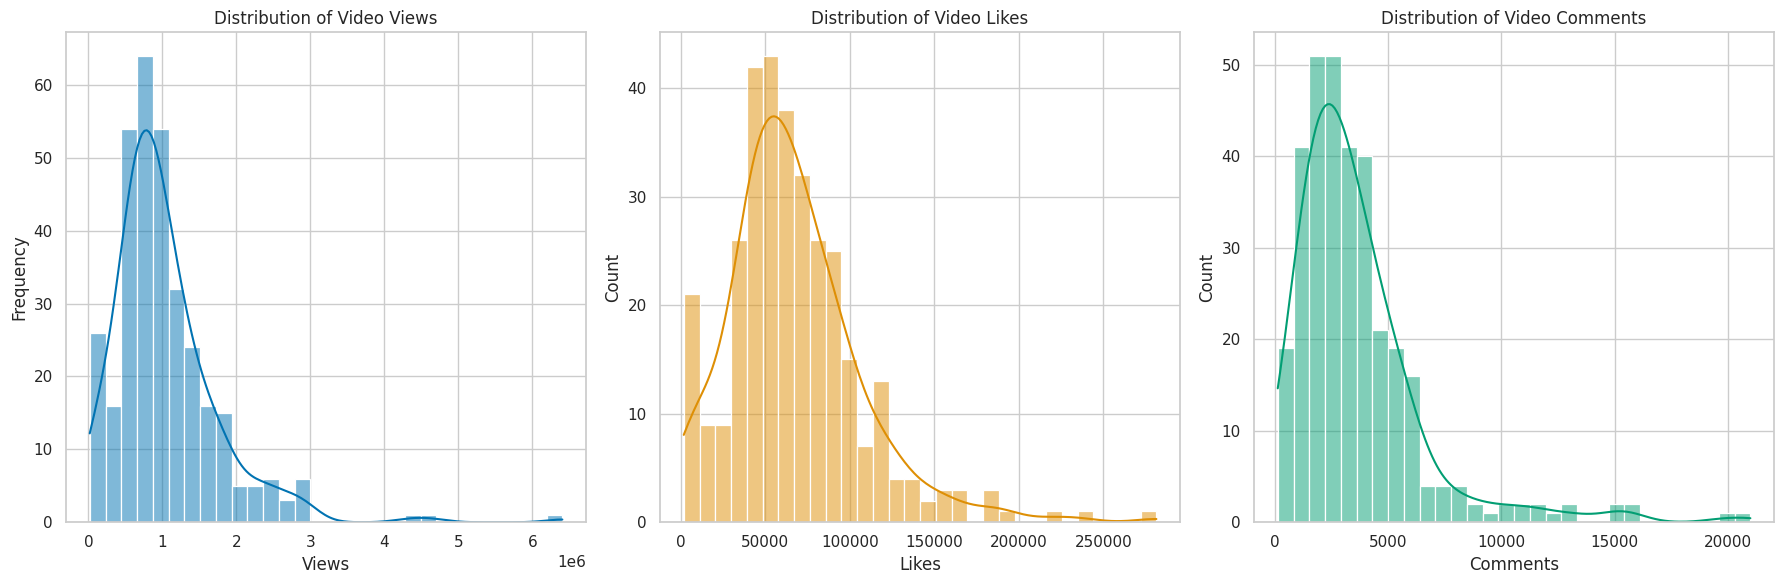

<ipython-input-4-fce985f39867>:40: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_cleaned.set_index('publish_date').resample('M')['title'].count().plot(marker='o', linestyle='-',


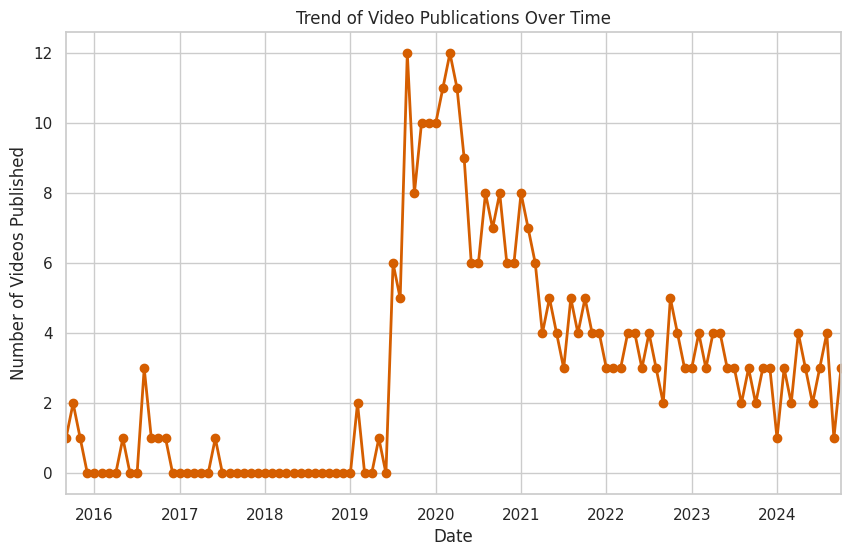

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load the cleaned videos data
df_cleaned = pd.read_csv("rebal_d_videos_cleaned.csv")

# Convert 'publish_date' to datetime format
df_cleaned['publish_date'] = pd.to_datetime(df_cleaned['publish_date'])

# Set the style for seaborn plots and use a color-blind friendly palette
sns.set(style="whitegrid")
color_palette = sns.color_palette("colorblind")

# Plot distributions for views, likes, and comments
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Video Views Distribution
sns.histplot(df_cleaned['view_count'], bins=30, kde=True, ax=axes[0], color=color_palette[0])  # First color for views
axes[0].set_title('Distribution of Video Views')
axes[0].set_xlabel('Views')
axes[0].set_ylabel('Frequency')

# Video Likes Distribution
sns.histplot(df_cleaned['like_count'], bins=30, kde=True, ax=axes[1], color=color_palette[1])  # Second color for likes
axes[1].set_title('Distribution of Video Likes')
axes[1].set_xlabel('Likes')

# Video Comments Distribution
sns.histplot(df_cleaned['comment_count'], bins=30, kde=True, ax=axes[2], color=color_palette[2])  # Third color for comments
axes[2].set_title('Distribution of Video Comments')
axes[2].set_xlabel('Comments')

plt.tight_layout()
plt.show()

# Plot the trend of video publications over time with thicker line and color-blind-friendly color
plt.figure(figsize=(10, 6))
df_cleaned.set_index('publish_date').resample('M')['title'].count().plot(marker='o', linestyle='-',
                                                                         color=color_palette[3],
                                                                         linewidth=2)
plt.title('Trend of Video Publications Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Videos Published')
plt.grid(True)  # Add grid for better readability
plt.show()

## Data Visualizations for Titles and Descriptions

The visualizations use **Seaborn** and **Matplotlib** with a color-blind-friendly palette.

- **Steps and Functionality**:
  1. **Data Loading**:
     - The cleaned video dataset is loaded from `rebal_d_videos_cleaned.csv`.

  2. **Feature Creation**:
     - Two new columns, `title_length` and `description_length`, are created to store the character counts of video titles and descriptions.

  3. **Visualizations**:
     - **Distribution of Title and Description Lengths**:
       - Two histograms are plotted to show the frequency distributions of title and description lengths. Both use KDE (kernel density estimates) to visualize the density of the data, making it easier to spot the most common lengths.
     
     - **Title Length vs Views** and **Description Length vs Likes**:
       - Scatter plots show the relationship between title/description lengths and engagement metrics.
       - Regression lines are added to each scatter plot to highlight potential trends or relationships.

  4. **Correlation Analysis**:
     - A **correlation matrix** is computed for `view_count`, `like_count`, `comment_count`, `title_length`, and `description_length`.
     - A **heatmap** is generated to visualize the strength of correlations between these variables, using a color-blind friendly **diverging palette**.

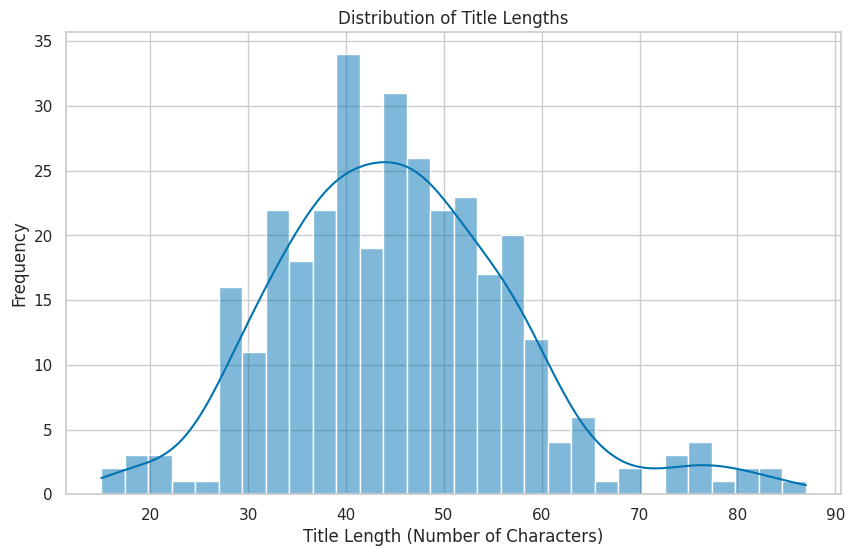

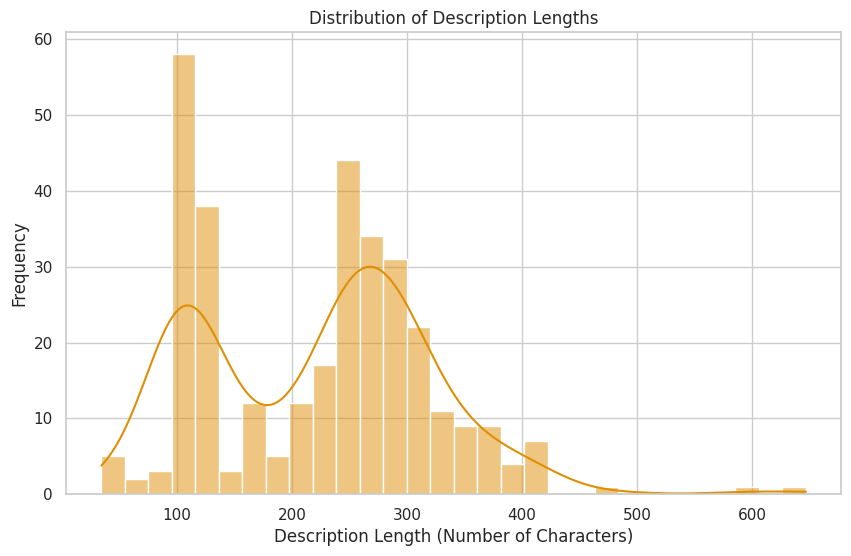

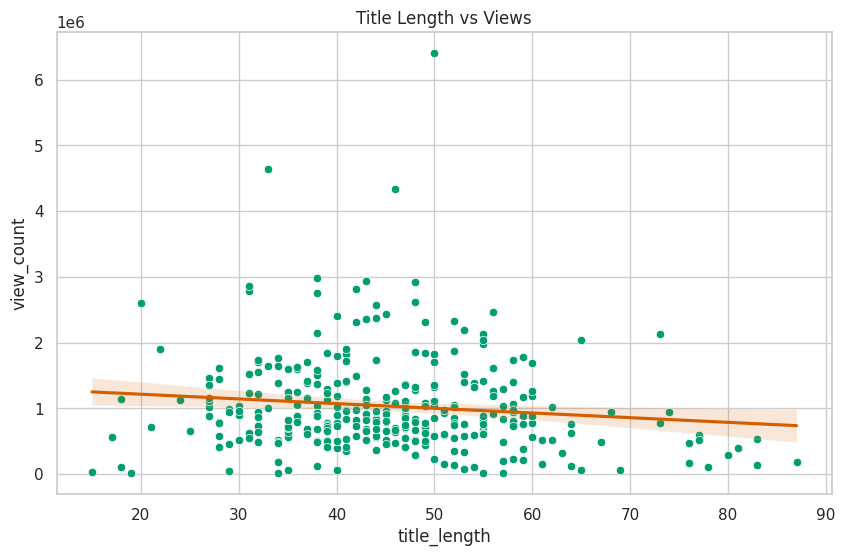

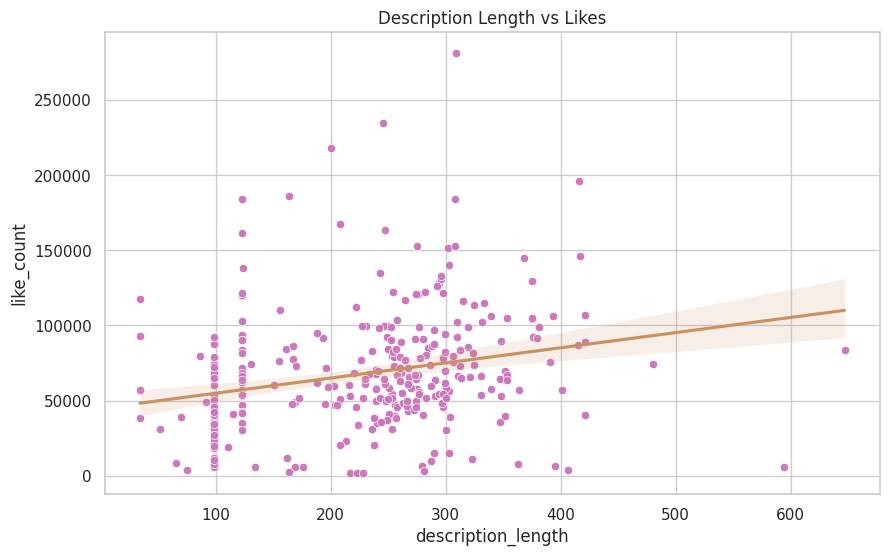

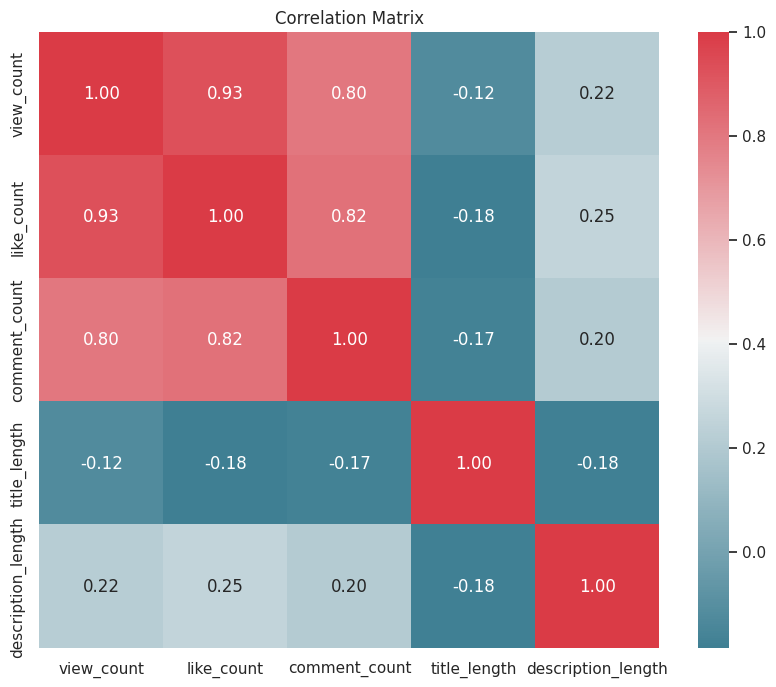

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the cleaned videos data
df_cleaned = pd.read_csv("rebal_d_videos_cleaned.csv")

# Create new columns for title length and description length
df_cleaned['title_length'] = df_cleaned['title'].apply(len)
df_cleaned['description_length'] = df_cleaned['description_cleaned'].apply(len)

# Set the color-blind friendly palette
color_palette = sns.color_palette("colorblind")

# Visualization of Title and Description Lengths

# Plotting title length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['title_length'], bins=30, kde=True, color=color_palette[0])  # First color for title length
plt.title('Distribution of Title Lengths')
plt.xlabel('Title Length (Number of Characters)')
plt.ylabel('Frequency')
plt.show()

# Plotting description length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['description_length'], bins=30, kde=True, color=color_palette[1])  # Second color for description length
plt.title('Distribution of Description Lengths')
plt.xlabel('Description Length (Number of Characters)')
plt.ylabel('Frequency')
plt.show()

# Correlation between title length and engagement (views, likes, comments)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='title_length', y='view_count', data=df_cleaned, color=color_palette[2])  # Third color for scatterplot
plt.title('Title Length vs Views')
plt.xlabel('Title Length (Number of Characters)')
plt.ylabel('Views')

# Add a regression line
sns.regplot(x='title_length', y='view_count', data=df_cleaned, scatter=False, color=color_palette[3])  # Fourth color for regression line
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='description_length', y='like_count', data=df_cleaned, color=color_palette[4])  # Fifth color for scatterplot
plt.title('Description Length vs Likes')
plt.xlabel('Description Length (Number of Characters)')
plt.ylabel('Likes')

# Add a regression line
sns.regplot(x='description_length', y='like_count', data=df_cleaned, scatter=False, color=color_palette[5])  # Sixth color for regression line
plt.show()

# Correlation matrix with color-blind friendly palette
correlation_matrix = df_cleaned[['view_count', 'like_count', 'comment_count', 'title_length', 'description_length']].corr()

# Use a diverging palette that is color-blind friendly for the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True), fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Sophisticated stuffs:

# Topic Modeling Using LDA (Latent Dirichlet Allocation)

The key goal is to identify meaningful topics from YouTube video descriptions and explore how different numbers of topics affect coherence. The process involves:

1. **Pre-processing the Video Descriptions**:
   - Descriptions are cleaned by removing numbers, punctuation, and stopwords, and words are lemmatized.
   - External links are also removed to ensure clean input data.

2. **Topic Coherence Testing**:
   - A custom function is created to test different topic numbers and calculate coherence scores, helping to determine the optimal number of topics. The coherence score measures how interpretable the topics are.
   - The range of topics tested is from 2 to 12 (in increments of 2), and coherence scores are plotted to visualize the results.

3. **LDA with 4 Topics**:
   - The script selects **4 topics**, based on coherence scores or interpretability, using a **TF-IDF matrix** as input. The `LatentDirichletAllocation` model is fitted to the cleaned descriptions.
   
4. **Displaying Topics**:
   - The top 10 words for each of the 4 topics are printed for analysis, providing insight into the structure of each topic.

5. **Assigning Topics to Each Video**:
   - A new column `topics` is added to the dataset, where each video is assigned one or more topics based on the probability distribution from LDA. If a topic’s probability is greater than 0.1 (adjustable), it is assigned to that video.

6. **Visualization of Coherence Scores**:
   - A color-blind-friendly plot is created to visualize coherence scores across different numbers of topics. This helps in selecting the most interpretable model.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


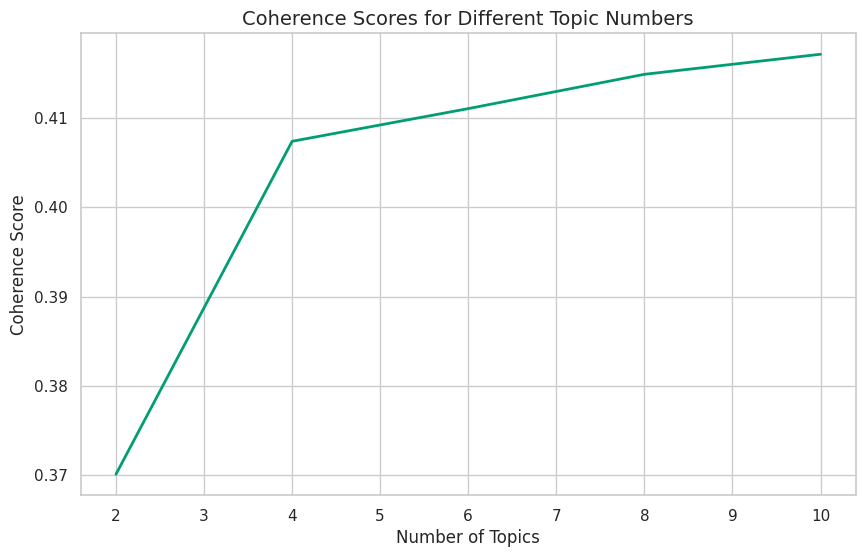

Topic 0:
tiktok girl look today boy trend tik tok guy toxic
Topic 1:
reballion join button hit sure subscribe merch store tiktok reacting
Topic 2:
dating girl look awkward guy time today movie merch store
Topic 3:
today hey people think video look best rebal channel girlfriend
                                       title  \
0         This Guy USES Girls for a LIVING 🤨   
1  This TikTok Girl Can't Handle Being Wrong   
2        This Skinny Coach is FOOLING US ALL   
3   The Downfall of TikTok's Biggest Hater 😶   
4    Everybody Hates This TikTok Mean Girl 🤡   

                                 topics  
0                    [Topic 0, Topic 2]  
1                    [Topic 0, Topic 3]  
2                    [Topic 0, Topic 2]  
3                             [Topic 3]  
4  [Topic 0, Topic 1, Topic 2, Topic 3]  


In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import CountVectorizer
import gensim

# Load data
df = pd.read_csv('rebal_d_videos_cleaned.csv')

# Download required packages
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize lemmatizer and stop words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Pre-process descriptions
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = text.split()  # Tokenize
    tokens = [word for word in tokens if len(word) > 2]  # Remove short words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatize & remove stopwords
    return ' '.join(tokens)

# Cleaning function to remove external links
def remove_links(text):
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove common URL patterns
    return text

# Apply cleaning functions to DataFrame
df['description_cleaned'] = df['description_cleaned'].apply(remove_links)
df['description_cleaned'] = df['description_cleaned'].apply(preprocess_text)

# Convert cleaned text into a CountVectorizer matrix for LDA
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
count_matrix = count_vectorizer.fit_transform(df['description_cleaned'])

# Function to test different numbers of topics and calculate coherence scores
def compute_coherence_values(texts, dictionary, corpus, start, limit, step):
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                random_state=42,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values

# Prepare corpus and dictionary for coherence calculations
texts = [desc.split() for desc in df['description_cleaned']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Run LDA with different numbers of topics to find optimal number
start, limit, step = 2, 12, 2  # Range of topics to test
model_list, coherence_values = compute_coherence_values(texts, dictionary, corpus, start, limit, step)

# Visualize the coherence score per number of topics
import matplotlib.pyplot as plt

# Set color-blind-friendly color palette for the plot
sns.set_palette(sns.color_palette("colorblind"))

# Plot Coherence Scores with thicker lines and improved colors
x = range(start, limit, step)
plt.figure(figsize=(10, 6))
plt.plot(x, coherence_values, color=sns.color_palette("colorblind")[2], linewidth=2)  # Thicker line and color-blind-friendly color
plt.xlabel("Number of Topics", fontsize=12)
plt.ylabel("Coherence Score", fontsize=12)
plt.title("Coherence Scores for Different Topic Numbers", fontsize=14)
plt.grid(True)  # Add grid for better readability
plt.show()

# Convert cleaned text into a TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['description_cleaned'])

# Select model with 4 topics
lda_4_topics = LatentDirichletAllocation(n_components=4, random_state=42)
lda_4_topics.fit(tfidf_matrix)  # Fit using tfidf_matrix

# Get top words per topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display topics with 4 topics and top 10 words
no_top_words = 10
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()  # Get feature names from TfidfVectorizer
display_topics(lda_4_topics, tfidf_feature_names, no_top_words)

# Assign topics to each video in a new column
df['topics'] = [[] for _ in range(len(df))]  # Initialize empty lists for topics

# Loop over each video and assign topics
for index, topic_distribution in enumerate(lda_4_topics.transform(tfidf_matrix)):
    for topic_idx, prob in enumerate(topic_distribution):
        if prob > 0.1:  # Adjust threshold as necessary
            df.at[index, 'topics'].append(f'Topic {topic_idx}')

# Check the DataFrame to ensure topics are assigned
print(df[['title', 'topics']].head())

# Network Analysis of Video-Topic Relationships

The main objectives are to visualize the relationships between videos and topics and to calculate centrality metrics that highlight the importance of each video within the network.

1. **Graph Creation**:
   - A NetworkX graph `G` is initialized, where each video is represented as a node.
   - Edges are created between each video and its corresponding topics, establishing connections based on the 'topics' column in the DataFrame.

2. **Graph Visualization**:
   - The graph is visualized using Matplotlib, with nodes displayed in light blue and edges set to a lower opacity for better clarity.
   - The spring layout algorithm is employed for node positioning, providing an aesthetically pleasing representation of the network.

3. **Centrality Metrics Calculation**:
   - Three centrality metrics are calculated for each node: betweenness centrality, degree centrality, and eigenvector centrality.
   - These metrics provide insights into the role and influence of each video within the topic network, indicating how videos serve as bridges or hubs within the structure.

4. **Results Verification**:
   - The code prints the length of the original DataFrame and the number of nodes in the graph to verify consistency and correctness.

5. **Centrality Data Storage**:
   - A new DataFrame is created to store the centrality values for each video, which is then merged with the original DataFrame. This allows for easy access to centrality metrics alongside video titles and topics for further analysis.

6. **Output Display**:
   - The updated DataFrame, including the calculated centrality metrics, is printed to provide a clear overview of how each video ranks in terms of its network influence.


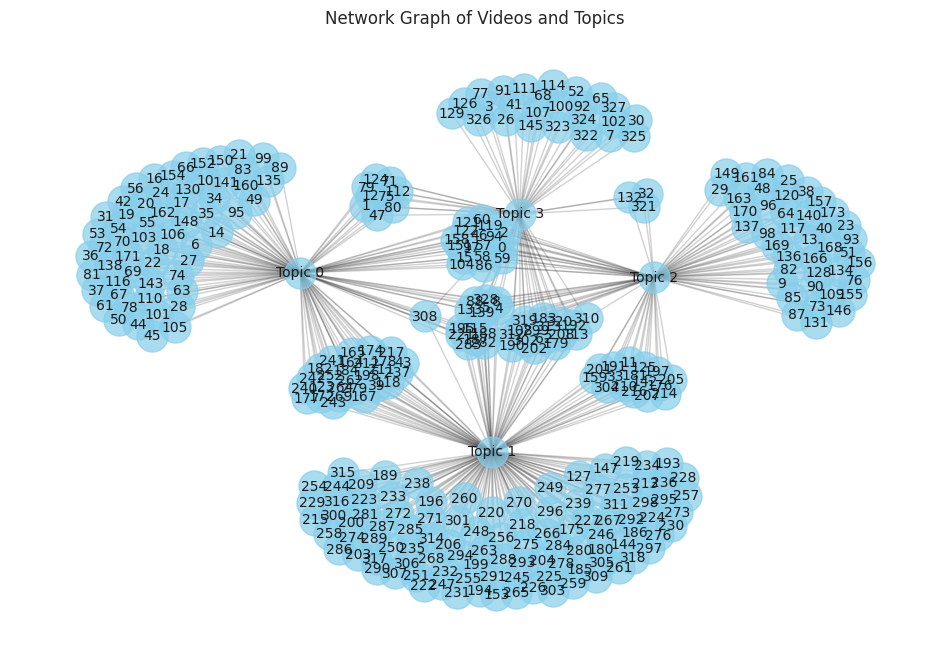

Length of DataFrame: 329
Number of nodes in graph: 333
                                                 title  \
0                   This Guy USES Girls for a LIVING 🤨   
1            This TikTok Girl Can't Handle Being Wrong   
2                  This Skinny Coach is FOOLING US ALL   
3             The Downfall of TikTok's Biggest Hater 😶   
4              Everybody Hates This TikTok Mean Girl 🤡   
..                                                 ...   
324  CUTE THINGS GIRLS DO THAT TURN GUYS ON IN SCHO...   
325                                TYPES OF CLASSMATES   
326                                    Types of Laughs   
327                      Types of High School Teachers   
328                                 If Cats Could Talk   

                                   topics  betweenness_centrality  \
0                      [Topic 0, Topic 2]                0.002328   
1                      [Topic 0, Topic 3]                0.002352   
2                      [Topic 0, Topic 2]

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a NetworkX graph
G = nx.Graph()

# Add nodes with video numbers and create edges
for index, row in df.iterrows():
    G.add_node(index)  # Use video index as node
    for topic in row['topics']:
        G.add_edge(index, topic)  # Create edges to topics

# Draw the network graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Positioning for the nodes

# Draw nodes and edges with transparency
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500, alpha=0.7)
nx.draw_networkx_edges(G, pos, alpha=0.2)  # Set edge transparency
nx.draw_networkx_labels(G, pos, labels={i: str(i) for i in G.nodes()}, font_size=10)  # Use video index as label

plt.title("Network Graph of Videos and Topics")
plt.axis('off')  # Hide axes
plt.show()

# Add centrality metrics to DataFrame
betweenness_centrality = nx.betweenness_centrality(G)
degree_centrality = nx.degree_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Check the lengths
print("Length of DataFrame:", len(df))
print("Number of nodes in graph:", len(G.nodes()))

# Create a new DataFrame to hold centrality values
centrality_data = {
    'node': list(G.nodes()),
    'betweenness_centrality': [betweenness_centrality[node] for node in G.nodes()],
    'degree_centrality': [degree_centrality[node] for node in G.nodes()],
    'eigenvector_centrality': [eigenvector_centrality[node] for node in G.nodes()]
}

# Convert to DataFrame
centrality_df = pd.DataFrame(centrality_data)

# Merge centrality metrics with the original DataFrame on the node
df['betweenness_centrality'] = centrality_df.set_index('node').reindex(df.index)['betweenness_centrality']
df['degree_centrality'] = centrality_df.set_index('node').reindex(df.index)['degree_centrality']
df['eigenvector_centrality'] = centrality_df.set_index('node').reindex(df.index)['eigenvector_centrality']

# Display updated DataFrame with relevant columns
print(df[['title', 'topics', 'betweenness_centrality', 'degree_centrality', 'eigenvector_centrality']])

# Sentiment Analysis and Emotion Detection

This section focuses on analyzing the sentiment and emotions expressed in the titles and descriptions of YouTube videos using VADER and a pre-trained emotion detection model. The primary steps involved are:

1. **VADER Initialization**:
   - The VADER sentiment analysis tool is initialized by downloading the necessary lexicon, which enables the assessment of sentiments in text.

2. **Sentiment Analysis**:
   - Sentiment scores for both titles and cleaned descriptions are calculated, resulting in compound sentiment values that reflect the overall sentiment.

3. **Sentiment Classification**:
   - Each title and description sentiment score is classified into three categories: positive, negative, or neutral, based on the compound score.

4. **Sentiment Distribution Visualization**:
   - Bar charts are created to visualize the distribution of sentiment classifications for both titles and descriptions, providing an overview of the prevailing sentiments.

5. **Emotion Detection Pipeline Initialization**:
   - An emotion detection pipeline is set up using a pre-trained DistilBERT model designed for classifying emotions in text.

6. **Emotion Extraction**:
   - Emotions for both titles and descriptions are extracted, resulting in a list of emotions with associated scores.

7. **Top Emotion Selection**:
   - The top emotion for each title and description is identified by selecting the emotion with the highest score from the detected emotions.

8. **Emotion Occurrence Counting**:
   - The occurrences of each detected emotion are counted for both titles and descriptions, facilitating a deeper understanding of the emotional landscape.

9. **DataFrame Conversion for Plotting**:
   - The counts of emotions for titles and descriptions are converted into DataFrames for ease of plotting.

10. **Emotion Distribution Visualization**:
    - Bar plots are generated to illustrate the distribution of emotions for both titles and descriptions, allowing for comparative analysis of emotional content.

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


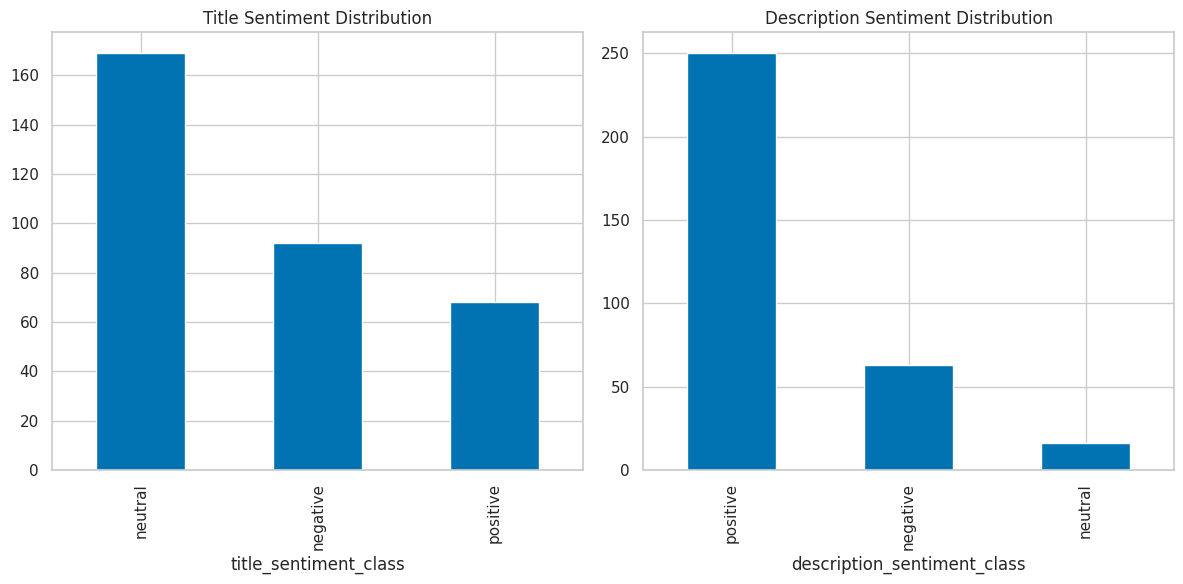

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
<ipython-input-8-e125b3ca3663>:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha="right")
<ipython-input-8-e125b3ca3663>:68: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha="right")


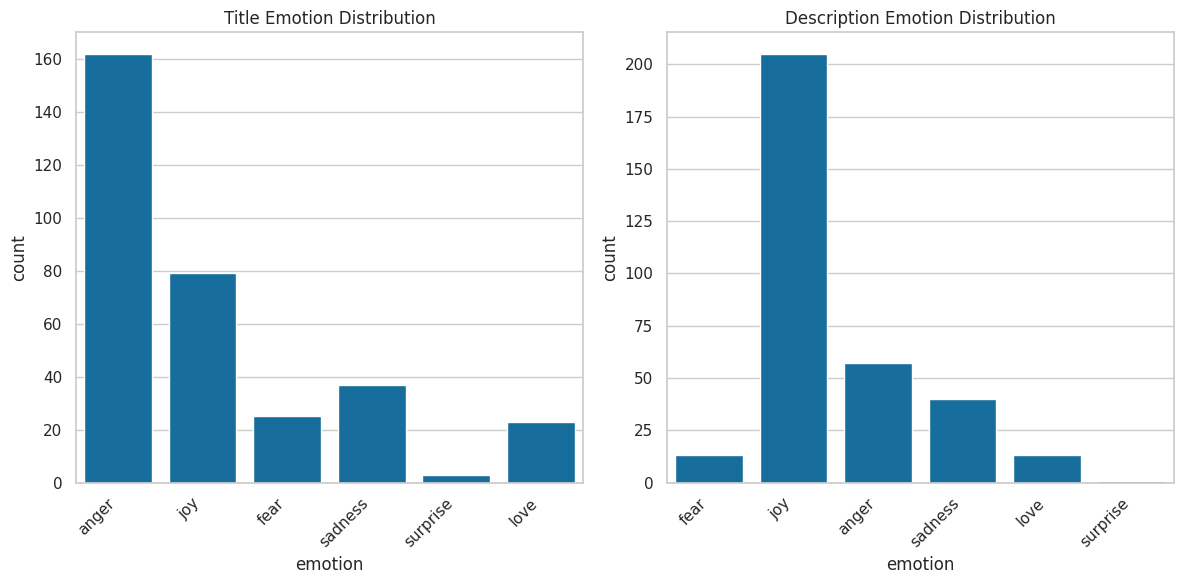

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import pipeline
from collections import Counter
import nltk

# Step 1: Initialize VADER for sentiment analysis
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Step 2: Sentiment analysis for both title and description
df['title_sentiment'] = df['title'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['description_sentiment'] = df['description_cleaned'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Step 3: Classify sentiment
df['title_sentiment_class'] = df['title_sentiment'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))
df['description_sentiment_class'] = df['description_sentiment'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

# Step 4: Plot sentiment distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

df['title_sentiment_class'].value_counts().plot(kind='bar', ax=ax[0], title='Title Sentiment Distribution')
df['description_sentiment_class'].value_counts().plot(kind='bar', ax=ax[1], title='Description Sentiment Distribution')

plt.tight_layout()
plt.show()

# Step 5: Initialize the emotion detection pipeline
emotion_pipeline = pipeline("text-classification", model="bhadresh-savani/distilbert-base-uncased-emotion")

# Step 6: Extract emotions for titles and descriptions
df['title_emotions'] = df['title'].apply(lambda x: emotion_pipeline(x))
df['description_emotions'] = df['description_cleaned'].apply(lambda x: emotion_pipeline(x))

# Step 7: Extract the top emotion for each title and description
def get_top_emotion(emotion_list):
    # Select the emotion with the highest score
    return max(emotion_list, key=lambda x: x['score'])['label']

df['title_top_emotion'] = df['title_emotions'].apply(get_top_emotion)
df['description_top_emotion'] = df['description_emotions'].apply(get_top_emotion)

# Step 8: Count the occurrences of each emotion for titles and descriptions
title_emotion_counts = Counter(df['title_top_emotion'])
description_emotion_counts = Counter(df['description_top_emotion'])

# Step 9: Convert to DataFrames for easy plotting
title_emotion_df = pd.DataFrame.from_dict(title_emotion_counts, orient='index', columns=['count']).reset_index()
description_emotion_df = pd.DataFrame.from_dict(description_emotion_counts, orient='index', columns=['count']).reset_index()

# Rename columns for clarity
title_emotion_df.columns = ['emotion', 'count']
description_emotion_df.columns = ['emotion', 'count']

# Step 10: Plot the emotion distribution for titles and descriptions
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot title emotions
sns.barplot(x='emotion', y='count', data=title_emotion_df, ax=ax[0])
ax[0].set_title('Title Emotion Distribution')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha="right")

# Plot description emotions
sns.barplot(x='emotion', y='count', data=description_emotion_df, ax=ax[1])
ax[1].set_title('Description Emotion Distribution')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

## Additional Investigation:

To verify the correctness of my sentiment and emotion classifications, I will sample a few rows of your data along with their predicted sentiments and emotions by randomly selecting a small number of video titles and descriptions, and displaying them along with the corresponding sentiment and emotion classifications. This will allow me to manually inspect the results and confirm if the predictions align with your expectations.

In [ ]:
import pandas as pd

# Assuming df is the DataFrame with your titles, descriptions, sentiment, and emotion predictions

# Set the number of samples to display
num_samples = 10  # Change this number as needed

# Randomly sample rows from the DataFrame
sampled_df = df.sample(num_samples)

# Select relevant columns (titles, descriptions, sentiment, and emotions)
sampled_df = sampled_df[['title', 'description_cleaned', 'title_sentiment_class', 'description_sentiment_class',
                         'title_top_emotion', 'description_top_emotion']]

# Display the sampled rows for inspection
print(sampled_df)

# If you want a more user-friendly display using pandas
pd.set_option('display.max_colwidth', None)  # Ensure full title and description text is shown
display(sampled_df)

                                                 title  \
238  TikTok GIRLS: I Only Look HOT From This Angle 😍👀📸   
52          This TikTok Man thinks he’s THE CHOSEN ONE   
12             This TikToker is a new kind of TOXIC ☣️   
174              TikTok GIRLS: I wish I was pretty.😞✋💔   
100  This Show Replaces Your Boyfriend with a "Hott...   
269  These TikToks will make you feel even more unc...   
54                 Please dump your Spotify Boyfriend.   
86                    TikTok's Toxic "Entrepreneurs" 🤡   
319  DR. BILL'S COUPLES THERAPY CLINIC || Comedy Sk...   
114      The Creepiest "InSpiRinG" Channel on YouTube-   

                                   description_cleaned title_sentiment_class  \
238  merch store anyway sure hit subscribe button j...               neutral   
52   today take look another tiktok conspiracy theo...               neutral   
12   linkrebalac today take look joseph antoni wate...               neutral   
174  merch store reacting reaction new ti

,title,description_cleaned,title_sentiment_class,description_sentiment_class,title_top_emotion,description_top_emotion
238,TikTok GIRLS: I Only Look HOT From This Angle 😍👀📸,merch store anyway sure hit subscribe button join reballion rebal_da,neutral,positive,love,joy
52,This TikTok Man thinks he’s THE CHOSEN ONE,today take look another tiktok conspiracy theorist guy think sun fake science real scientist lying worst part explanation still managed convince people somehow correct rebal_da,neutral,negative,joy,sadness
12,This TikToker is a new kind of TOXIC ☣️,linkrebalac today take look joseph antoni water day guy water tok yes water tok entire genre tiktok water enthusiast would drink anything actual water rebal_da,neutral,positive,anger,joy
174,TikTok GIRLS: I wish I was pretty.😞✋💔,merch store reacting reaction new tiktok tik tok trend boy guy honest pull challenge ask would date look tiktok girl even harder watch anyway sure hit subscribe button join reballion rebal_da,positive,positive,joy,joy
100,"This Show Replaces Your Boyfriend with a ""Hotter"" one 🤡",merch store bestie here mtvs parental control show basically controlling parent decide dont like daughter boyfriend want replace hotter cuter guy yes cringe rebal_da,neutral,positive,anger,anger
269,These TikToks will make you feel even more uncomfortable 😶👀🙆,tiktoks tik toks going make feel uncomfortable itchy inside weird tiktok tik tok girl boy took challenge anyway sure hit subscribe button join reballion rebal_da,negative,negative,fear,fear
54,Please dump your Spotify Boyfriend.,today take look spotify boyfriend guy boy decided good idea make playlist pretending boyfriend dont feel lonely single well reaction rebal_da,negative,positive,anger,sadness
86,"TikTok's Toxic ""Entrepreneurs"" 🤡",today take look one challenge tiktok entrepreneur trader real estate investor girl boy show got super successful dropping friend unfollowing celebrity sure youve seen page lmao rebal_da,neutral,positive,anger,joy
319,DR. BILL'S COUPLES THERAPY CLINIC || Comedy Skit || Rebal,hey reballion today video finally comedy skit called anyway sure hit subscribe button join reballion rebal_da,positive,positive,joy,joy
114,"The Creepiest ""InSpiRinG"" Channel on YouTube-",merch store reacting reaction another episode sameer bhavnani inspiring content creator basically copy dharman word word think dharman lot creepier worse overall lmao rebal_da,neutral,positive,joy,joy


### Sentiment Analysis

**Title Sentiment:**

- **Neutral:** Titles like "TikTok GIRLS: HIGHSCHOOL GLOW UPS" reflect a lack of strong emotion.
  
- **Positive:** Titles such as "This Man Rates Girls' Worth with Money" express strong opinions.

- **Negative:** Titles like "the most EMBARRASSING DATING SHOW" are clearly critical.

**Description Sentiment:**

- **Neutral/Positive:** Neutral phrases, e.g., "hit subscribe button join reballion," align with mild sentiment.
  
- **Negative:** Critiques like "the most EMBARRASSING DATING SHOW" fit a negative classification.

### Emotion Classifications

**Title Emotions:**

- **Anger:** Titles like "TikTok Thinks Your Relationship is TOXIC" fit anger due to negative language, while others may reflect disgust instead.

- **Joy:** Titles such as "TikTok GIRLS: HIGHSCHOOL GLOW UPS" match a joyful tone.

**Description Emotions:**

- **Anger/Joy:** Descriptions like "This Man Rates Girls' Worth" reflect mixed emotions.

- **Sadness/Fear:** Phrases like "the most EMBARRASSING DATING SHOW" evoke sadness, while "ghosting" may signal fear.

### Areas of Concern

- **Anger in Titles:** Some titles classified as anger, like "TikTok GIRLS: HIGHSCHOOL GLOW UPS," may require reevaluation.

- **Joy in Descriptions:** Descriptions of awkward moments could be better categorized as sadness or disgust.

- **Emotion Overlap:** Mixed emotions (e.g., anger and joy) in descriptions suggest potential classification confusion.

- **Sarcasm:** Rebal D's use of sarcasm complicates sentiment analysis, leading to misclassifications due to the nuanced meanings of words.